In [37]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
from fredapi import Fred
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from fredapi import Fred
from IPython.display import Image
%matplotlib inline
warnings.filterwarnings('ignore')
data = pd.read_csv('data/inflation_usa_csv_2.csv', sep = ';')

In [3]:
fred = Fred(api_key='f4d3adb4893b55ab18a4677c8e8f7f28')

# 👨‍💻 Inflation forecasting using machine learning 📊

<font size = "6">**What is inflation?**<font>

In [ ]:
from IPython import display
display.Image("img/picture.jpg")

<font size = "5">**Motivation of the project**<font> 
- Forecasting macroeconomic conditions such as inflation is of fundamental importance for households, businesses and governments
- With rising inflation, social inequality increases as poorer households are hit the hardest by price increases
- Traditional forecasting models using macroeconometrics techniques involves discretionary choices about data and models
- Forecasts based on expert judgement (i.e. surveys) might be based on wrong intuitions
- Can we use machine learning (ML) / deep learning (DL) techniques to predict inflation?

<font size = "5"><font> 

<font color='green'>Pros</font>👍
- ML/DL techniques let the data speak
- ML/DL techniques better capture non-linearities in the data
- The available literature says that forecasts from different ML/DL models generally perform better than traditional models

<font color='red'>Cons</font>👎
- Models are mostly not transparent ('black box')
- It is important to have a theory of how the economy works!
- ML/DL models work better on large datasets (only few years/months of data available in macro)

# Studies forecasting inflation using ML
- Frade Moro (2022) uses deep learning (LSTM) to forecast inflation for Brazil using several features (e.g. BRL-USD exchange-rate, base interest rate)
- Kohlscheen (2021) examines the drivers of inflation for 20 advanced economies using random forests
- Other studies have investigated the performance of different ML models on the forecast of other macroeconomic variables (unemployment, gdp growth)

In [4]:
df = {}
df['Consumer Price Index'] = fred.get_series('CPIAUCSL')
df['Core Consumer Price Index'] = fred.get_series('CPILFESL')
df = pd.DataFrame(df)
df['Consumer Price Index MOM'] = round((df['Consumer Price Index'].pct_change().fillna(0))*100,2)
df['Consumer Price Index YOY'] = round((df['Consumer Price Index'].pct_change(12).fillna(0))*100,2)
df_new = df.reset_index(level=0).copy().rename(columns={"index": "Time"})
df_new['Time'] = pd.to_datetime(df_new['Time'])
df_new = df_new.loc[df_new["Time"] >= "1960-01-01"]
df_new['Growth Rate CPI'] = df_new['Consumer Price Index'].pct_change(periods=12) * 100
df_new['Growth Rate CCPI'] = df_new['Core Consumer Price Index'].pct_change(periods=12) * 100
df_new.dropna(inplace=True)

# Let's take a look at the data on inflation for the US

In [34]:
config = {'displayModeBar': False}

fig = go.Figure()

fig.add_trace(go.Scatter(x = df_new["Time"], 
                         y = df_new['Growth Rate CPI'], 
                         name = "CPI", 
                         mode = "lines"))
fig.add_trace(go.Scatter(x = df_new["Time"], 
                         y = df_new['Growth Rate CCPI'], 
                         name = "Core CPI", 
                         mode = "lines"))

fig.add_hline(y=0, line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
    title = "CPI and Core CPI for the US (Jan-1961 - Jan-2023", 
    xaxis_title = "Time", 
    yaxis_title = "Monthly y-o-y percentage change",
    autosize=False,
    width=890,
    height=600,
  legend = dict(
        xanchor = "center",
        yanchor = "top",
        y = -0.2, 
        x = 0.5,
        orientation = 'h'
  )
)

fig.show(config=config)

<font size = "5">What is the goal of our project?<font> 
- Train a model to predict inflation using different ML/DL techniques
- We will initially focus on the US to then then extend out project to other countries (e.g. eurozone countries)
- The data will be obtained using different python packages (essentially APIs) such as *Fred* for US data
- We will build a dashboard where the user will have the opportunity to:
    - Select a country
    - Select a time horizon
    - Obtain the inflation forecast for the selected country/time parameters
    - The model will be trained as new macroeconomic data are published

In [48]:
model_fit = pm.auto_arima(df_new['Growth Rate CCPI'], 
                          test='adf', 
                          max_p=3, max_d=3, max_q=3, 
                          seasonal=True, m=12,
                          max_P=3, max_D=2, max_Q=3,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3508.453, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4367.030, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2721.214, Time=0.23 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2711.292, Time=0.98 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=2705.240, Time=2.36 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=2714.740, Time=4.31 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=2711.727, Time=1.07 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=6.56 sec
 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=-150.692, Time=7.14 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-121.740, Time=3.88 sec
 ARIMA(1,0,1)(3,0,1)[12] intercept   : AIC=i

In [49]:
pred = model_fit.predict_in_sample(start=1, end=len(df_new['Growth Rate CCPI']), dynamic=False)

# Preliminary analysis

In [57]:
config = {'displayModeBar': False}

fig = go.Figure()

fig.add_trace(go.Scatter(x = df_new["Time"], 
                         y = df_new['Growth Rate CCPI'], 
                         name = "Core CPI", 
                         mode = "lines"))
fig.add_trace(go.Scatter(x = df_new["Time"], 
                         y = pred, 
                         line_color="green",
                         name = "Predicted Core CPI", 
                         mode = "lines"))

fig.update_layout(
    title = "ARIMA(3,0,3)(3,0,0)[12]", 
    xaxis_title = "Time", 
    yaxis_title = "Monthly y-o-y percentage change",
    autosize=False,
    width=890,
    height=600,
  legend = dict(
        xanchor = "center",
        yanchor = "top",
        y = -0.2, 
        x = 0.5,
        orientation = 'h'
  )
)

fig.show(config=config)

In [53]:
h = 24
forecast = model_fit.predict(h)
min_date = str(df_new['Time'].values[:1][0])[0:10]
max_date = str(df_new['Time'].values[-1:][0])[0:10]
t = pd.date_range(min_date, max_date, freq='MS')
forecast_df = pd.DataFrame([[x, y] for x, y in zip(t, pred)], columns=["Time", "Forecast"])
min_date = "2023-02-01"
max_date = "2025-02-01"
t = pd.date_range(min_date, max_date, freq='MS')
out_forecast_df = pd.DataFrame([[x, y] for x, y in zip(t, forecast)], columns=["Time", "Forecast"])
df_new_short = df_new.loc[df_new["Time"] >= "2015-01-01"]

# Montly y-o-y inflation forecast from February 2023 until January 2025

In [58]:
config = {'displayModeBar': False}

fig = go.Figure()


fig.add_trace(go.Scatter(x = df_new_short["Time"], 
                         y = df_new_short['Growth Rate CCPI'], 
                         name = "Core CPI", 
                         mode = "lines"))

fig.add_trace(go.Scatter(x = out_forecast_df["Time"], 
                         y = out_forecast_df['Forecast'], 
                         name = "Forecasted Core CPI",
                         line_dash = "dash", 
                         line_color = "black",
                         mode = "lines"))
fig.add_vrect(x0 = "2023-01-01", 
              x1 = "2025-01-01",  
              fillcolor = "grey", 
              opacity = 0.25, 
              line_width = 0)

fig.update_layout(
    title = "Out-of-sample forecast until Jan 2025", 
    xaxis_title = "Time", 
    yaxis_title = "Monthly y-o-y percentage change",
    autosize=False,
    width=890,
    height=600,
  legend = dict(
        xanchor = "center",
        yanchor = "top",
        y = -0.2, 
        x = 0.5,
        orientation = 'h'
  ),
)

fig.show(config=config)

<font size = "5">**How do we proceed?**<font>

<font size = "5"><font> 
- We will first gather data to investigate the main determinants of inflation (features selection and features processing) 📝

<font size = "5"><font>
- We will try different ML/DL models (e.g. RNN LSTM, XGBoost, etc.); **PS:** there are numerous studies available so we won't be lost 😉

<font size = "5"><font>
- We will build our frontend product, i.e. the dashboard 📈

<font size = "5"><font> 
- We will put the model into "production" 😎

# Some exploratory work on the determinants of inflation..

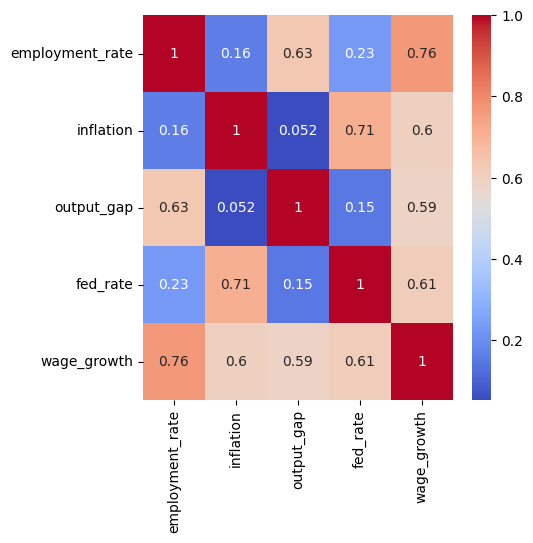

In [46]:
plt.figure(figsize = (5, 5))

sns.heatmap(
    data.drop(['year'], axis=1).corr(), 
    cmap = 'coolwarm', 
    annot = True, 
    annot_kws = {"size": 10}
);

In [30]:
model1 = smf.ols('inflation ~ output_gap + employment_rate + fed_rate + wage_growth', data=data).fit()
model2 = smf.ols('inflation ~ output_gap + fed_rate + wage_growth', data=data).fit()
model3 = smf.ols('inflation ~ fed_rate', data=data).fit()
stargazer = Stargazer([model3, model2, model1])
stargazer.covariate_order(['fed_rate', "output_gap", 'wage_growth', 'employment_rate'])

# Literature 📜

- Aaron Smalter Hall (2018): Machine Learning Approaches to Macroeconomic Forecasting. Federal Reserve Bank of Kansas City
- Emanuel Kohlscheen (2021): What does machine learning say about the drivers of inflation? BIS Working Papers, No 980 
- Pedro Guilherme Frade Moro (2021) Inflation Forecasting with Deep Learning. https://medium.com/analytics-vidhya/inflation-forecasting-with-deep-learning-d3067711fff1

<center><font size = "8">It would be great if you will consider to participate in this project!<font>

<center> <font size = "8">Thanks for your attention!! 🐤 <font>